## Import the necessary libraries

In [71]:
import pandas as pd                                    #Data Manipulation library
import numpy as np                                     #Numerical Computing library
import matplotlib.pyplot as plt                        #Data Visualization library
import seaborn as sns                                  #Data Visualization library built on top of Matplotlib
from sklearn.preprocessing import MinMaxScaler         #Feature scaling method
from sklearn.impute import SimpleImputer               #Handling missing data
import joblib                                          #Importing & Exporting Model/Parameters

#Splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split   

#Evaluation metrics for machine learning models
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report 

## Load Datasets

In [2]:
triage_data = pd.read_csv('./dataset/triage.csv')
edstays_data = pd.read_csv('./dataset/edstays.csv')

In [3]:
# Merge the two datasets on the 'subject_id' and 'stay_id' columns
merged_dataset = pd.merge(triage_data, edstays_data[['subject_id','stay_id','intime','disposition']], on=['subject_id','stay_id'])

In [4]:
merged_dataset.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,intime,disposition
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension,2180-07-22 16:24:00,HOME
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention",2180-05-06 19:17:00,ADMITTED
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain",2180-08-05 20:58:00,ADMITTED
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention,2180-06-26 15:54:00,ADMITTED
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",2180-07-23 05:54:00,ADMITTED


In [34]:
dataset = merged_dataset[["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain","acuity"]]

In [35]:
# Count the amount of data before preprocessing
count_before = len(dataset)
print("Data count before: ", count_before)

Data count before:  425087


## Data Pre-processing

### Drop Null Values

In [36]:
dataset.dropna(axis=0, how='any', inplace=True)

C:\Users\hamma\AppData\Local\Temp\ipykernel_8128\333416206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(axis=0, how='any', inplace=True)


### Check for Non-numeric Data

In [37]:
for column in dataset.columns:
    try:
        pd.to_numeric(dataset[column])
    except ValueError:
        print(f"{column} contains non-numeric data.")

pain contains non-numeric data.


### Cleaning Random Text Values from pain Column

In [38]:
mask = dataset['pain'].str.contains('___') #De-identified data

deidentified_rows = dataset[mask].index
dataset = dataset.drop(index=deidentified_rows)

dataset['pain'] = pd.to_numeric(dataset['pain'], errors='coerce') # Removing random text values from column
dataset.dropna(subset=['pain'], inplace=True)

In [11]:
dataset.head(5)

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0
1,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0
2,99.4,105.0,18.0,96.0,106.0,57.0,10.0,3.0
3,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0
4,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0


### Data Normalization

In [39]:
# Normalization
scaler = MinMaxScaler()
columns = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
dataset[columns] = scaler.fit_transform(dataset[columns])

In [72]:
min_value, max_value = scaler.data_min_, scaler.data_max_
joblib.dump((min_value, max_value), 'minmax.joblib')

['minmax.joblib']

In [40]:
dataset.head(5)

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,0.099097,0.077617,0.007692,0.010405,0.003345,0.000065,0.059259,2.0
1,0.099706,0.062274,0.008791,0.010405,0.005119,0.000095,0.007407,3.0
2,0.100720,0.093863,0.009890,0.010298,0.005119,0.000086,0.081481,3.0
3,0.100213,0.078520,0.009890,0.010405,0.005626,0.000133,0.081481,3.0
4,0.100010,0.068592,0.008791,0.010513,0.004612,0.000076,0.103704,2.0


In [41]:
# Count the amount of data after preprocessing
count_after = len(dataset)
print("Data after normalization: ", count_after)

Data after normalization:  380155


## Checking Dataset for Imbalance

Float64Index([3.0, 2.0, 4.0, 1.0, 5.0], dtype='float64')
[56.13341926 33.12490958  7.18917284  3.28208231  0.27041601]


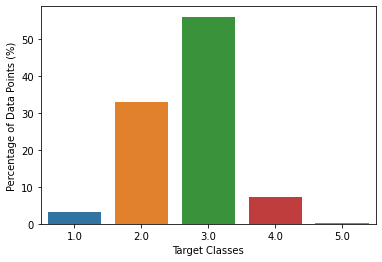

In [42]:
# Get the value counts for the target column
target_counts = dataset['acuity'].value_counts()

# Calculate the percentage of data points for each class
target_percentage = target_counts / dataset.shape[0] * 100

# Plot the distribution using seaborn
sns.barplot(x=target_percentage.index, y=target_percentage.values)

print(target_percentage.index)
print(target_percentage.values)

plt.xlabel('Target Classes')
plt.ylabel('Percentage of Data Points (%)')
plt.show()

Dataset is imbalanced. However performing oversampling or undersampling will heavily reduce model accuracy to the 20s.<br>

Will be performing a combination of oversampling and undersampling although this will not balance the data, we just want to improve the accuracy of successfully classifying classes 1 and classes 5 under the target column.

## Combination Sampling

Combining over-sampling and under-sampling methods for imbalanced datasets

In [43]:
from imblearn.combine import SMOTEENN 

In [44]:
# Get the features and target columns
X = dataset[['temperature','heartrate','resprate','o2sat','sbp','dbp','pain']]
y = dataset['acuity']

In [45]:
# Perform SMOTE and ENN
smote_enn = SMOTEENN(sampling_strategy='not majority')
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [46]:
# Combine the resampled features and target into a new DataFrame
dataset_resampled = pd.DataFrame(np.column_stack([X_resampled, y_resampled]), columns=dataset.columns)

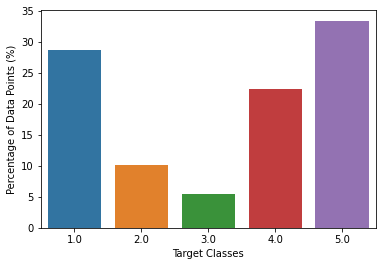

In [47]:
# Get the value counts for the target column
target_counts = dataset_resampled['acuity'].value_counts()

# Calculate the percentage of data points for each class
target_percentage = target_counts / dataset_resampled.shape[0] * 100

# Plot the distribution using seaborn
sns.barplot(x=target_percentage.index, y=target_percentage.values)
plt.xlabel('Target Classes')
plt.ylabel('Percentage of Data Points (%)')
plt.show()

In [48]:
# Count the amount of data after preprocessing
count = len(dataset_resampled)
print("Data count after sampling: ", count)

Data count after sampling:  629738


In [49]:
dataset_resampled.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,0.097272,0.099278,0.010989,0.010727,0.004156,0.000097,0.044444,1.0
1,0.100720,0.073105,0.007692,0.010727,0.003751,0.000071,0.081481,1.0
2,0.098894,0.065884,0.009890,0.010727,0.008059,0.000122,0.007407,1.0
3,0.099604,0.091155,0.009890,0.010405,0.003497,0.000068,0.103704,1.0
4,0.098996,0.057762,0.009890,0.010727,0.006488,0.000101,0.007407,1.0


In [50]:
dataset_resampled.to_csv('./dataset/preprocessed_classif_data.csv', index=False)

---

# Load Preprocessed Data

In [51]:
classif_dataset = pd.read_csv('./dataset/preprocessed_classif_data.csv')

## Data Split - Diagnostic Stage

In [61]:
# Define the features and the target for the diagnostic stage
x_diagnosis = classif_dataset[['temperature','heartrate','resprate','o2sat','sbp','dbp','pain']]
y_diagnosis = classif_dataset['acuity']

In [62]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

## Voting Classifier

The voting classifier combines the predictions of other classifiers to get a prediction that is more accurate. With hard voting, the majority class's prediction serves as the outcome.

In [63]:
#Ensemble method for combining multiple classifiers
from sklearn.ensemble import VotingClassifier

# Model Classifiers Used
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#Initializing Classifiers
dt_model = DecisionTreeClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

In [64]:
# Creating the hybrid model using the voting classifier
hybrid_model = VotingClassifier(estimators=[('rf', rf_model), ('dt', dt_model),('gb', gb_model)], voting='hard')

In [65]:
# Fitting the voting classifier on the training data
hybrid_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))])

In [66]:
# Making predictions on the test set
predictions = hybrid_model.predict(X_test)

In [67]:
print(predictions)

[2. 4. 1. ... 5. 5. 1.]


In [68]:
# Evaluating the hybrid model on the test set
accuracy = hybrid_model.score(X_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8937021627973449


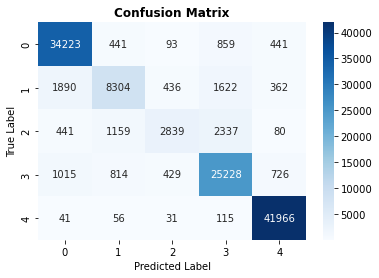

Accuracy score: 89.37021627973449
Recall score: [0.94913609 0.65831616 0.41408985 0.89422941 0.99424293]
Precision score: [0.90994416 0.77074438 0.74164054 0.83644441 0.96307516]
              precision    recall  f1-score   support

         1.0       0.91      0.95      0.93     36057
         2.0       0.77      0.66      0.71     12614
         3.0       0.74      0.41      0.53      6856
         4.0       0.84      0.89      0.86     28212
         5.0       0.96      0.99      0.98     42209

    accuracy                           0.89    125948
   macro avg       0.84      0.78      0.80    125948
weighted avg       0.89      0.89      0.89    125948



In [69]:
# Creating a confusion matrix 
cf_matrix = confusion_matrix(y_test, predictions)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",  weight='bold')
plt.show()

#Printing Accuracy, Recall and Precision Scores
ac = accuracy_score(y_test, predictions)
rs = recall_score(y_test, predictions, average=None)
ps = precision_score(y_test, predictions, average=None)
print("Accuracy score: " + str(ac*100))
print("Recall score: " + str(rs))
print("Precision score: " + str(ps))

# Print the evaluation of the model
print(classification_report(y_test, predictions))

## Export the Model

In [116]:
# Dump the model to a file
joblib.dump(hybrid_model, 'hybridmodel.joblib')

['hybridmodel.joblib']